## Import all of used library 
is needed to run all of the cells in this section

In [1]:
# Import library that needed for colab
from google.colab import drive # colab only
from google.colab import files # colab only

# To remove all warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2, VGG16, EfficientNetB0, InceptionV3, \
                                           VGG19, Xception, DenseNet121, DenseNet201, ResNet152V2, EfficientNetB5
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow import lite, cast, float32
from tensorflow import saved_model

from imblearn.over_sampling import RandomOverSampler 

In [2]:
# To mounting Google Drive

def google_drive_mount(mounting=False):
  if mounting:
    drive.mount('/content/drive')

In [3]:
# Download the file

def download_file(urls, unzip=True, remove_after_unzip=False, google_drive=False, filename='tmp', ext='zip'):

  url = urls
  CHUNK_SIZE = 32768
  file_tmp = f'{filename}.{ext}'

  # If Downloading from Google Drive
  if google_drive:

    # Get the token
    def get_confirm_token(response):
      
      for key, value in response.cookies.items():
        if key.startswith('download_warning'):
          return value
      return None
    
    url_raw = 'https://docs.google.com/uc?export=download'
    file_id = url.split('/')[-2] # Split the file id
    session = requests.Session() # Get session
    response = session.get(url_raw, params={'id': file_id}, stream=True) # Get the response
    token = get_confirm_token(response) # Get the token

    # If there is token
    if token:
      response = session.get(url_raw, params={'id': file_id, 'confirm': token}, stream=True) # Get the response
    
    # Save the response as zip file
    with open(file_tmp, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)
  
  # If not from Google Drive
  else:
    filedata = get_file(origin=url, fname=os.path.join(os.getcwd(), file_tmp)) # Get the response from URL

  # Extract the zip files
  if unzip:
    local_zip = file_tmp
    zip_ref = zipfile.ZipFile(local_zip, 'r') # Extract 
    zip_ref.extractall(f'{os.getcwd()}/') # Extract
    zip_ref.close()
    # Remove the zip file after unzip
    if remove_after_unzip:
      os.remove(file_tmp)  
  
  # If not a zip file
  else:
    return file_tmp

In [4]:
# Load the saved models/checkpoints models from Google Drive

def load_models(url, summary=False, filenames='tmp'):
  model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext="h5", filename=filenames)  
  model = load_model(model_download)
  if summary:
    model.summary()
  return model

## Loading the Models
Load the checkpoint model (with keras *.h5 format) and testing with testing portion on the datasets from Google Drive: 'https://drive.google.com/file/d/1-0ODyEWBJcERmvXXM5Ejk_VoxV7gI6SW/view?usp=sharing'

In [5]:
links = 'https://drive.google.com/file/d/1-0ODyEWBJcERmvXXM5Ejk_VoxV7gI6SW/view?usp=sharing'
model = load_models(links)

## Testing the datasets
We gonna test the previous datasets with 2370 data by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1-dOK_6g-Bkf8_SKcZKUwiCIj8TSqC7O5/view?usp=sharing

Download the datasets

In [ ]:
# Download the datasets
download_file('https://drive.google.com/file/d/1-dOK_6g-Bkf8_SKcZKUwiCIj8TSqC7O5/view?usp=sharing', remove_after_unzip=True, google_drive=True)

len(os.listdir('data'))

2370

Define datasets from csv to split images and labels

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels
  df_unique = df['cell_type'].value_counts() # Amout of unique value

  if unique: # Counting unique values
    return img, target, df_unique
  
  if show_df:
    return img, target, df
  
  else:
    return img, target

In [ ]:
# Defining dataset into labels and features
img, target = define_dataset('metadata.csv')

From image, convert to tensor

In [ ]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [ ]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 2370/2370 [00:04<00:00, 481.46it/s]


Scoring the datasets

In [ ]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [ ]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 96.88%


Plot Confusion Matrix

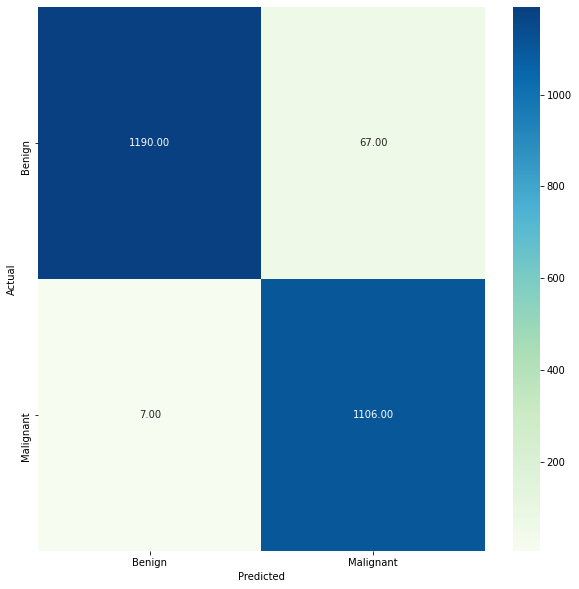

In [ ]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing another datasets to make the sure the models is good
We gonna test the another datasets with 4515 data by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1056M1Q1qKlrXjepEmZ7AdeJiVjuhpGHQ/view

Download the datasets

In [ ]:
# Download the datasets
download_file('https://drive.google.com/file/d/1056M1Q1qKlrXjepEmZ7AdeJiVjuhpGHQ/view', remove_after_unzip=True, google_drive=True)

len(os.listdir('HAM10000-fix'))

4515

Define datasets from csv to split images and labels

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    df['cell_type'] = df['cell_type'].replace('Melanocytic nevi', 'Benign')
    df['cell_type'] = df['cell_type'].replace('Melanoma', 'Malignant')
    df['cell_type'] = df['cell_type'].replace('Benign keratosis-like lesions', 'Benign')
    df['cell_type'] = df['cell_type'].replace('Basal cell carcinoma', 'Benign')
    df['cell_type'] = df['cell_type'].replace('Actinic keratoses', 'Benign')
    df['cell_type'] = df['cell_type'].replace('Vascular lesions', 'Benign')
    df['cell_type'] = df['cell_type'].replace('Dermatofibroma', 'Benign')
    df['cell_type_idx'] = df['cell_type_idx'].replace(0, 0)
    df['cell_type_idx'] = df['cell_type_idx'].replace(1, 0)
    df['cell_type_idx'] = df['cell_type_idx'].replace(2, 0)
    df['cell_type_idx'] = df['cell_type_idx'].replace(3, 0)
    df['cell_type_idx'] = df['cell_type_idx'].replace(4, 0)
    df['cell_type_idx'] = df['cell_type_idx'].replace(5, 1)
    df['cell_type_idx'] = df['cell_type_idx'].replace(6, 0)
    img = df['image_id'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [ ]:
# Defining dataset into labels and features
img, target = define_dataset('metadata.csv')

From image, convert to tensor

In [ ]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"HAM10000-fix/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [ ]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 4515/4515 [00:10<00:00, 446.48it/s]


Scoring the datasets

In [ ]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [ ]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 83.65%


Plot Confusion Matrix

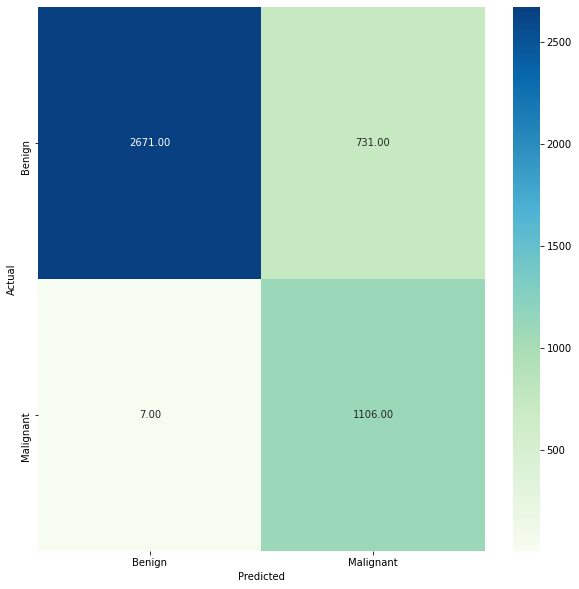

In [ ]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing another datasets with real HAM10000
We gonna test the another datasets with 10015 data by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1hTV43J0etH5nI5z1Y0Fsq1LFrrvjRONc/view?usp=sharing <br> source from: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

Download the datasets

In [ ]:
# Download the datasets
download_file('https://drive.google.com/file/d/1hTV43J0etH5nI5z1Y0Fsq1LFrrvjRONc/view?usp=sharing', remove_after_unzip=True, google_drive=True)

len(os.listdir('data'))

10015

Define datasets from csv to split images and labels

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    img = df['image_id'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [ ]:
# Defining dataset into labels and features
img, target, uniq = define_dataset('metadata.csv', unique=True)
uniq

Benign       8902
Malignant    1113
Name: cell_type, dtype: int64

From image, convert to tensor

In [ ]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [ ]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 10015/10015 [00:18<00:00, 536.83it/s]


Scoring the datasets

In [ ]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [ ]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 73.08%


Plot Confusion Matrix

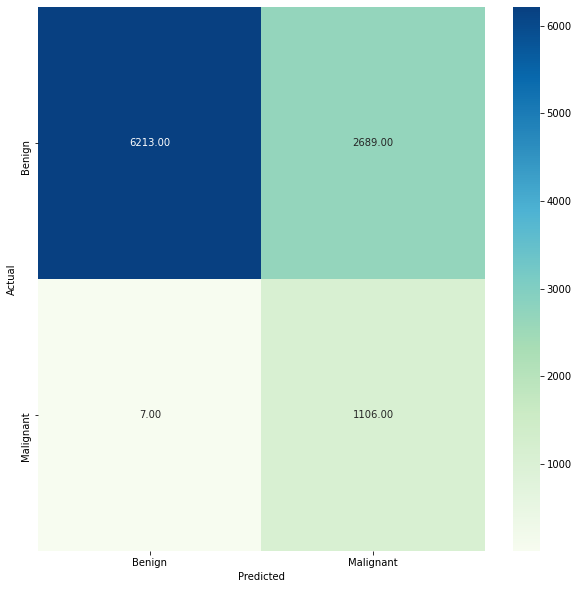

In [ ]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing another datasets with Benign only
We gonna test the another datasets with only data of benign (15000) by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1EhtH3NmIIDw3dGU9iXec2OCgL_wCYsO0/view?usp=sharing <br> source from: https://www.kaggle.com/cdeotte/jpeg-melanoma-384x384

Why this dataset? because we gonna test the model with only data of benign to make sure this data is well predicting benign

Download the datasets

In [ ]:
# Download the datasets
download_file('https://drive.google.com/file/d/1EhtH3NmIIDw3dGU9iXec2OCgL_wCYsO0/view?usp=sharing', remove_after_unzip=True, google_drive=True)

Define datasets from csv to split images and labels

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    img = df['image_name'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [ ]:
# Defining dataset into labels and features
img, target, unique = define_dataset('metadata.csv', unique=True)
unique

Benign    15000
Name: cell_type, dtype: int64

From image, convert to tensor

In [ ]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [ ]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 15000/15000 [00:12<00:00, 1180.30it/s]


Scoring the datasets

In [ ]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [ ]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 78.94%


Plot Confusion Matrix

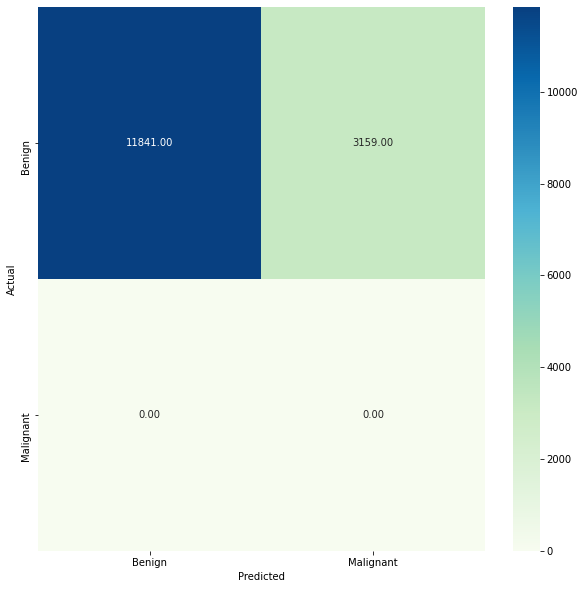

In [ ]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing another datasets with Malignant only



We gonna test the another datasets with only data of malignant (15000) by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/163G6mvjRJdPCvOAGNau7jyThiZJBqFiQ/view?usp=sharing <br> source from: https://www.kaggle.com/andrewmvd/isic-2019

Why this dataset? because we gonna test the model with only data of malignant to make sure this data is well predicting malignant

Download the datasets

In [ ]:
# Download the datasets
download_file('https://drive.google.com/file/d/163G6mvjRJdPCvOAGNau7jyThiZJBqFiQ/view?usp=sharing', remove_after_unzip=True, google_drive=True)
print(len(os.listdir('dataset_melanoma')))

15000


Define datasets from csv to split images and labels

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    img = df['image_id'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [ ]:
# Defining dataset into labels and features
img, target, unique = define_dataset('metadata.csv', unique=True)
unique

Malignant    15000
Name: cell_type, dtype: int64

From image, convert to tensor

In [ ]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"dataset_melanoma/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [ ]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 15000/15000 [00:18<00:00, 826.12it/s]


Scoring the datasets

In [ ]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [ ]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 72.63%


Plot Confusion Matrix

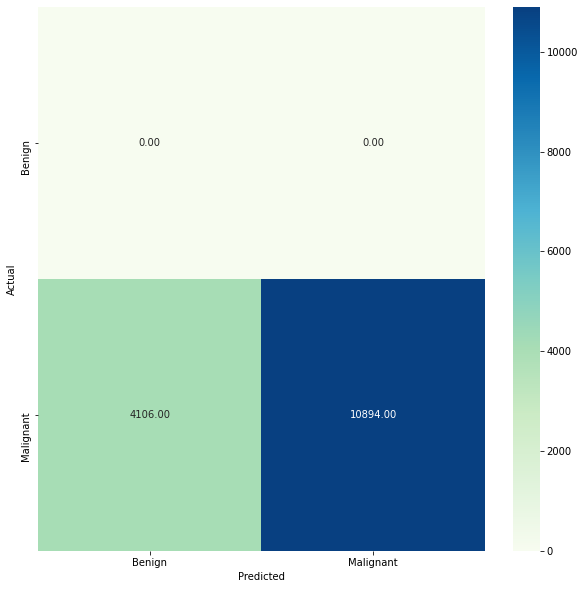

In [ ]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing more another datasets to make the sure the models is good
We gonna test the another datasets with 16000 data by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1LawCmFsbGkBE19JY86wOpM_eqSOcnlXe/view <br> source from: https://kaggle.com/shonenkov/merge-external-data

Download the datasets

In [6]:
# Download the datasets
download_file('https://drive.google.com/file/d/1LawCmFsbGkBE19JY86wOpM_eqSOcnlXe/view', remove_after_unzip=True, google_drive=True)

len(os.listdir('data'))

16000

Define datasets from csv to split images and labels

In [8]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    img = df['image_id'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [9]:
# Defining dataset into labels and features
img, target, unq = define_dataset('metadata.csv', unique=True)
unq

Benign       8000
Malignant    8000
Name: cell_type, dtype: int64

From image, convert to tensor

In [12]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"data/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [13]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 16000/16000 [00:13<00:00, 1161.56it/s]


Scoring the datasets

In [18]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [19]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 78.36%


Plot Confusion Matrix

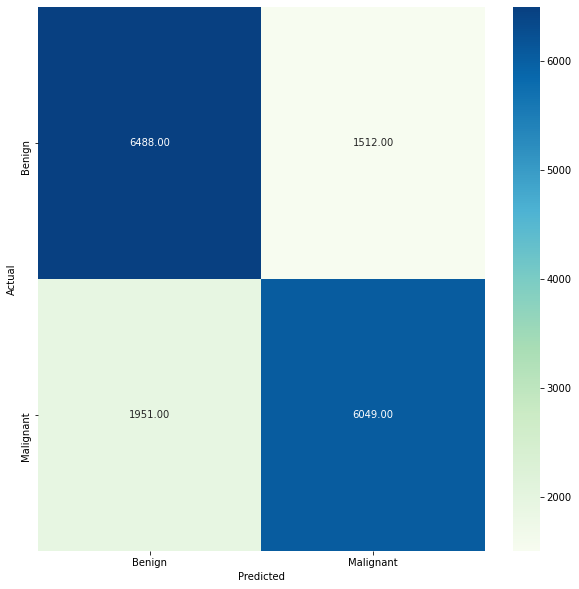

In [20]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing more another datasets to make the sure the models is good
We gonna test the another datasets with 2750 data by using the saved model from previous training, here is the datasets: https://drive.google.com/file/d/1UzmnfGM709na-LkJVc8ex60R7UeEN1w9/view?usp=sharing <br> source from: https://www.kaggle.com/wanderdust/skin-lesion-analysis-toward-melanoma-detection

Download the datasets

In [6]:
# Download the datasets
download_file('https://drive.google.com/file/d/1UzmnfGM709na-LkJVc8ex60R7UeEN1w9/view?usp=sharing', remove_after_unzip=True, google_drive=True)

len(os.listdir('data'))

2750

Define datasets from csv to split images and labels

In [7]:
def define_dataset(csv, unique=False, show_df = False):

    df = pd.read_csv(csv) # Reading the csv files from pandas
    img = df['image_id'] # Define the Feature 
    target = df['cell_type_idx'].values # Define the Labels
    df_unique = df['cell_type'].value_counts() # Amout of unique value

    if unique: # Counting unique values
        return img, target, df_unique
  
    if show_df:
        return img, target, df
  
    else:
        return img, target

In [8]:
# Defining dataset into labels and features
img, target, unq = define_dataset('metadata.csv', unique=True)
unq

Benign       2229
Malignant     521
Name: cell_type, dtype: int64

From image, convert to tensor

In [11]:
def to_tensor(image_paths, target, size=64):
 
  imgs = []
  
  for i in tqdm(image_paths):
    img = load_img(f"data/{i}", target_size=(size, size)) # Load the Image then resized them
    img = img_to_array(img) # Convert the Image to arrays
    img = img.astype(np.float32) / 255 # Rescale the Images
    imgs.append(img) # Load all of Images to datasets
  imgs = np.stack(imgs, axis=0) # Stack the image into numpy arrays
    
  return imgs, target

In [12]:
x_test, y_test = to_tensor(img, target, size=150)

100%|██████████| 2750/2750 [00:02<00:00, 1125.60it/s]


Scoring the datasets

In [13]:
# Scoring saved models/checkpoint models

class_names = ['Benign', 'Malignant']

def scoring(model, x_test, y_test, class_names, verbose=0, 
            returning='confusion_matrix', show_predict=False, 
            show_confusion_matrix=False, show_score=False):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sn.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    if returning in ['score', 'scoring']:
        score = model.evaluate(x_test, y_test, verbose=verbose)
        if show_score:
            print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    if returning in ['predicting', 'pred', 'predict']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        if show_predict:
            print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, pred)*100))

    if returning in ['conf', 'confusion_matrix', 'confussion', 
                    'confusion', 'conf_mat', 'confusion_mat']:
        predicting = model.predict(x_test)
        pred = np.argmax(predicting, axis=1)
        conf = confusion_matrix(y_test, pred) 
        if show_confusion_matrix:
            plot_confusionmat(conf, class_names)    

In [14]:
scoring(model, x_test, y_test, class_names, returning='predict', show_predict=True)

Accuracy: 57.31%


Plot Confusion Matrix

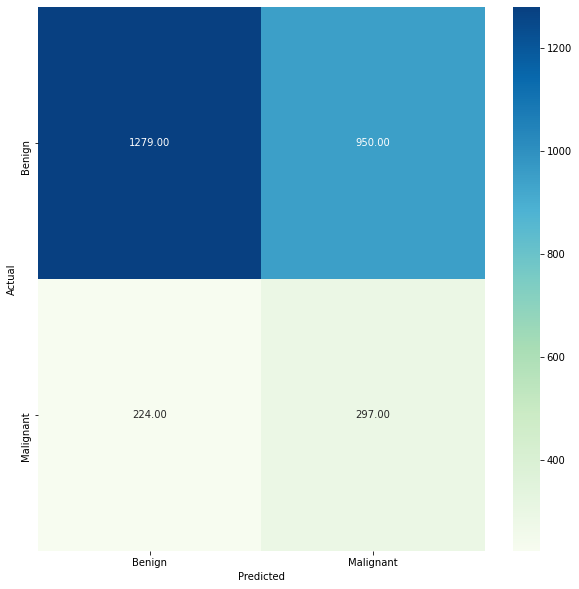

In [15]:
scoring(model, x_test, y_test, class_names, returning='conf', show_confusion_matrix=True)

## Testing from single image

In [ ]:
class_names_long = ['Benign', 'Malignant']

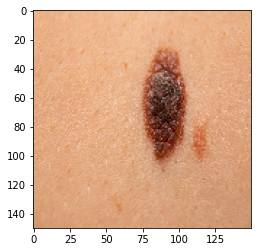


Predicting: 97.38% of Malignant
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here

# this is for general testing

imgs = []


path = '/content/malignant-melanoma.jpg'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}")
if class_names_long[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

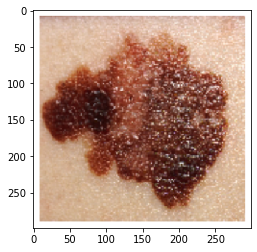

[[0.49454185 0.9937225 ]]

Predicting: 99.37% of Malignant
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here
# Model 3

imgs = []

path = '/content/download.png'
  
plt.imshow(load_img(path, target_size=(299, 299)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(predictions)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

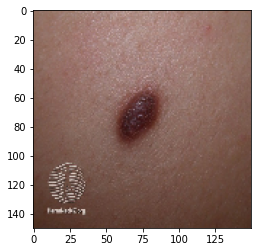

[[0.96923804 0.8184088 ]]

Predicting: 96.92% of Benign
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


In [ ]:
# test some picture here

imgs = []

path = '/content/Hyperpigmentation_in_dermatofibroma.jpg'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(predictions)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

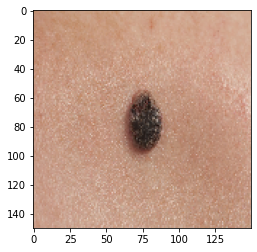

[[0.95550364 0.87927544]]

Predicting: 95.55% of Benign
Kind of Cancer: Benign
Benign means it is not a dangerous cancer or not a cancer


In [ ]:
# test some picture here

imgs = []

path = '/content/beginicaramengobatibasalcellcarcinoma.jpg'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(predictions)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

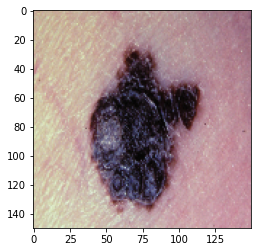

[[0.52869236 0.9999654 ]]

Predicting: 100.00% of Malignant
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here

imgs = []

path = '/content/Severe_superficial_spreading_melanoma-1296x728-Gallery1.jpg'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(predictions)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

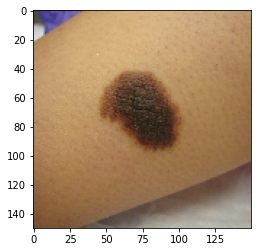

[[0.8507678 0.9890676]]

Predicting: 98.91% of Malignant
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here

imgs = []

path = '/content/melanocytic nevi.jpg'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)

print(predictions)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Malignant':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

## Convert Keras Model to Tensorflow SavedModel (Optional)
Purposed in this section to convert checkpoint model (keras *.h5 format) to SavedModel Tensorflow format, in order you want to deploy it to web or Google Cloud or something that needed Tensorflow SavedModel

In [ ]:
def KerastoSavedModel(links, mounting=False, make_archive=False, move_to_drive=True):

    # Mount Google Drive
    google_drive_mount(mounting=mounting)

    # Load model from Keras
    model = load_models(links)

    # Convert it to SavedModel
    if mounting:
        saved_model.save(model, '/content/drive/MyDrive/fix-datasets/models')

    else:
        saved_model.save(model, '/content/models')

    if make_archive:
        # Store it on zip files
        if mounting:
            make_archive('models', 'zip', '/content/drive/MyDrive/fix-datasets/models') # Create the new zip file

        else:
            make_archive('models', 'zip', '/content/models') # Create the new zip file

    if move_to_drive:
        # Move it to drive
        move('/content/models.zip', '/content/drive/MyDrive/fix-datasets/')

In [ ]:
links = 'https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing'
KerastoSavedModel(links, mounting=True, make_archive=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/fix-datasets/models/assets


'/content/models.zip'

Load the models from above (Google Drive): https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing

In [ ]:
# Just run this cell, because SavedModel has been hosted in Google Drive
# Download the models from Google Drive: https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing
# Then load the models
path_to_models = '/content/models'

if not os.path.exists(path_to_models):
    os.mkdir(path_to_models)

os.chdir(path_to_models)

download_file('https://drive.google.com/file/d/1-UCuB8mIvQNST7sTFmEiwN3DLeJRq2qw/view?usp=sharing', remove_after_unzip=True, google_drive=True)

model = load_model(path_to_models)

For testing purposed

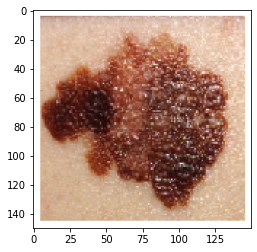


Predicting: 89.59% of Melanoma
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer


In [ ]:
# test some picture here

imgs = []

path = 'download.png'
  
plt.imshow(load_img(path, target_size=(150, 150)))
plt.show()
  
img = load_img(path, target_size=(150, 150))
img = img_to_array(img)
img = img.astype(np.float32) / 255
imgs.append(img)

imgs = np.stack(imgs, axis=0)

predictions = model.predict(imgs)
pred = np.argmax(predictions, axis=1)
  
print(f"\nPredicting: {(np.max(predictions))*100:.2f}% of {class_names_long[pred[0]]}") 
if class_names_long[pred[0]] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

## Load it to Tensorflow-lite (Optional)
Purposed in this section to convert checkpoint model (keras *.h5 format) to Tensorflow lite format, in order you want to deploy it to web, embedded, mobile or microcontroller devices

In [ ]:
def to_tflite(links, tflite_filename = 'converted_model.tflite', optimizations='size'):
    
    model = load_models(links)
    converter = lite.TFLiteConverter.from_keras_model(model)
    
    if optimizations in ['size', 'SIZE']:
        converter.optimizations = [lite.Optimize.OPTIMIZE_FOR_SIZE]
    
    if optimizations in ['latency', 'LATENCY']:
        converter.optimizations = [lite.Optimize.OPTIMIZE_FOR_LATENCY]
    
    tflite_model = converter.convert()
    
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)
    
    return tflite_filename

In [ ]:
links = 'https://drive.google.com/file/d/1-4HGDErWwQbvMERzcOWU8RSvN9Y7xxqu/view?usp=sharing' # Load Keras Models or SavedModel
tflite_filename = to_tflite(links)

INFO:tensorflow:Assets written to: /tmp/tmp5wtsyo22/assets


For testing the converted models

In [ ]:
# Assign labels
labels = []
for i in class_names_long:
    labels.append(i)

# Load lite model
interpreter = lite.Interpreter(tflite_filename)
interpreter.allocate_tensors()

# Get I/O details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image
img = Image.open('download.png').convert('RGB')

# Show image
#plt.imshow(img)
#plt.show()
#print(" ")

# Get input size
input_shape = input_details[0]['shape']
size = input_shape[:2] if len(input_shape) == 3 else input_shape[1:3]

# Preprocess image
img = img.resize(size)
img = np.array(img)
img = img.astype(np.float32) / 255
img = np.expand_dims(img, axis=0)

# Run the interpreter
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()

# The predictions
predictions = interpreter.get_tensor(output_details[0]['index'])[0]
pred = np.argmax(predictions)

# The results
print(f'Predicting {predictions[pred]*100:.2f}% of {labels[pred]}')
if labels[pred] != 'Melanoma':
  print("Kind of Cancer: Benign")
  print("Benign means it is not a dangerous cancer or not a cancer")
else:
  print("Kind of Cancer: Malignant")
  print("Malignant means dangerous and deadliest cancer")

Predicting 94.37% of Melanoma
Kind of Cancer: Malignant
Malignant means dangerous and deadliest cancer
